In [ ]:
# pip install burr[start,opentelemetry] opentelemetry-instrumentation-openai

In [1]:
import copy

from IPython.display import Image, display
from IPython.core.display import HTML 
import openai
import os
from llama_index.core import VectorStoreIndex, Document
from llama_index.llms.ollama import Ollama
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import fitz  # PyMuPDF
import sqlite3
from datetime import datetime
import threading
import uuid

from burr.core import ApplicationBuilder, State, default, graph, when
from burr.core.action import action
from burr.tracking import LocalTrackingClient

# Function to extract text from the PDF
def extract_text_from_pdf(pdf_file_bytes):
    pdf_doc = fitz.open(stream=pdf_file_bytes, filetype="pdf")
    text = ""
    for page_num in range(pdf_doc.page_count):
        page = pdf_doc.load_page(page_num)
        text += page.get_text("text")
    return text

@action(reads=[], writes=["vector_store"])
def process_pdf(state: State, pdf_file_bytes: bytes) -> State:
    extracted_text = extract_text_from_pdf(pdf_file_bytes)
    document = Document(text=extracted_text)
    # Specify a Hugging Face model for local embeddings
    embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
    index = VectorStoreIndex.from_documents([document], embed_model=embed_model)
    return state.update(vector_store=index)

@action(reads=["vector_store", "conversation_history"], writes=["conversation_history"])
def query_vector_store(state: State, query: str, model_choice: str) -> State:
    if model_choice == "Local (Ollama)":
        llm = Ollama(model="llama2", request_timeout=60.0)
    elif model_choice == "OpenAI":
        # Use OpenAI's model, get API key from environment variable
        openai_api_key = os.getenv("OPENAI_API_KEY")
        llm = OpenAI(api_key=openai_api_key, model="gpt-4o-mini")
    else:
        raise ValueError(f"Invalid model choice {model_choice}")
    index = state["vector_store"]
    query_engine = index.as_query_engine(llm=llm)
    
    conversation_history = state["conversation_history"]
    conversation = ""
    for h in conversation_history:
        conversation += f"User: {h[0]}\nAssistant: {h[1]}\n"
    conversation += f"User: {query}\n"
    
    response = query_engine.query(conversation)
    conversation_history.append((query, response))
    return state.update(conversation_history=conversation_history)

/Users/stefankrawczyk/.pyenv/versions/AI-for-SWEs-py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


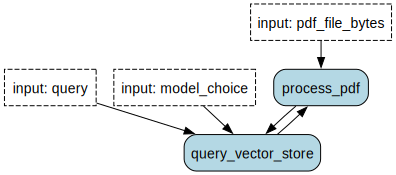

In [2]:
# Built the graph.
base_graph = (
    graph.GraphBuilder()
    .with_actions(
        # these are the "nodes" 
        process_pdf=process_pdf,
        query_vector_store=query_vector_store,
    )
    .with_transitions(
        # these are the edges between nodes, based on state.
        ("process_pdf", "query_vector_store", default),
        ("query_vector_store", "process_pdf", default),
    )
    .build()
)
base_graph.visualize()

Attempting to instrument while already instrumented


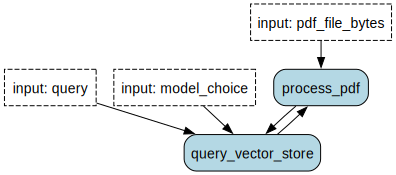

In [5]:
from opentelemetry.instrumentation.openai import OpenAIInstrumentor
# this will auto instrument the openAI client. No swapping of imports required!
OpenAIInstrumentor().instrument()

tracker = LocalTrackingClient(project="ai-for-swes")
app = (
    ApplicationBuilder()
    .with_graph(base_graph)
    .initialize_from(
        tracker, 
        resume_at_next_action=True, 
        default_state={"conversation_history": []},
        default_entrypoint="process_pdf",
    )
    .with_tracker(tracker, use_otel_tracing=True)  # tracking + checkpointing; one line 🪄.
    .build()
)
app